In [179]:
from random import random, randint, seed, uniform
from statistics import mean
from copy import deepcopy
import matplotlib.pyplot as plt
import math

In [196]:
POP_SIZE        = 60   # population size
MIN_DEPTH       = 6    # minimal initial random tree depth
MAX_DEPTH       = 8    # maximal initial random tree depth
GENERATIONS     = 250  # maximal number of generations to run evolution
TOURNAMENT_SIZE = 5    # size of tournament for tournament selection
XO_RATE         = 0.8  # crossover rate 
PROB_MUTATION   = 0.1  # per-node mutation probability 

In [197]:
def add(x, y): return x + y
def sub(x, y): return x - y
def mul(x, y): return x * y
def sq_add(x,y): 
    return x**2 + y**2
#def div(x,y): return x/y # Consider what issues might arrise with this function
def fib(x,y): return target_func(x)
FUNCTIONS = [add, sub, mul,sq_add]
TERMINALS = ['x', *range(-10,10,1)]

def target_func(n): # fibonacci numbers
    if n == 0:
        return 0
    elif n == 1:
        return 1
    else:
        a, b = 0, 1
        for _ in range(2, int(n)+1):
            a, b = b, a + b
        return b
    
# Define the sequence from OEIS A005875
target_sequence_sum_3squares = [1, 6, 12, 8, 6, 24, 24, 0, 12, 30, 24, 24, 8, 24, 48, 0, 6, 48, 36, 24, 24, 48, 24, 0, 24, 30, 72, 32]

# Define the sequence from OEIS A250000
target_sequence_peaceful_queens = [0, 0, 1, 2, 4, 5, 7, 9, 12, 14, 17, 21, 24, 28, 32, 37, 42, 47, 52, 58, 64, 70, 77, 84, 91, 98, 105, 114, 122, 131]

# Define the sequence from OEIS A004215
target_sequence_4squares= [7,15,23,28,31,39,47,55,60,63,71,79,87,92,95,103, 
 111,112,119,124,127,135,143,151,156,159,167,175,
 183,188,191,199,207,215,220,223,231,239,240,247,
 252,255,263,271,279,284,287,295,303,311,316,319,
 327,335,343]


def generate_dataset():
    dataset = []
    for x in range(len(target_sequence_peaceful_queens)): 
        # x/=100
        dataset.append([x, target_sequence_peaceful_queens[x]])
    return dataset

# def generate_dataset():
#     dataset = []
#     for x in range(1,11): 
#         # x/=100
#         dataset.append([x, target_func(x)])
#     return dataset

In [198]:
class GPTree:
    def __init__(self, data = None, left = None, right = None):
        self.data  = data
        self.left  = left
        self.right = right
        
    def node_label(self): # string label
        if (self.data in FUNCTIONS):
            return self.data.__name__
        else: 
            return str(self.data)
    
    def print_tree(self, prefix = ""): # textual printout
        print("%s%s" % (prefix, self.node_label()))        
        if self.left:  self.left.print_tree (prefix + "   ")
        if self.right: self.right.print_tree(prefix + "   ")

    def compute_tree(self, x): 
        if (self.data in FUNCTIONS): 
            return self.data(self.left.compute_tree(x), self.right.compute_tree(x))
        elif self.data == 'x': return x
        else: return self.data
            
    def random_tree(self, grow, max_depth, depth = 0): # create random tree using either grow or full method
        if depth < MIN_DEPTH or (depth < max_depth and not grow): 
            self.data = FUNCTIONS[randint(0, len(FUNCTIONS)-1)]
        elif depth >= max_depth:   
            self.data = TERMINALS[randint(0, len(TERMINALS)-1)]
        else: # intermediate depth, grow
            if random () > 0.5: 
                self.data = TERMINALS[randint(0, len(TERMINALS)-1)]
            else:
                self.data = FUNCTIONS[randint(0, len(FUNCTIONS)-1)]
        if self.data in FUNCTIONS:
            self.left = GPTree()          
            self.left.random_tree(grow, max_depth, depth = depth + 1)            
            self.right = GPTree()
            self.right.random_tree(grow, max_depth, depth = depth + 1)

    def mutation(self):
        if random() < PROB_MUTATION: # mutate at this node
            self.random_tree(grow = True, max_depth = 2)
        elif self.left: self.left.mutation()
        elif self.right: self.right.mutation() 

    def size(self): # tree size in nodes
        if self.data in TERMINALS: return 1
        l = self.left.size()  if self.left  else 0
        r = self.right.size() if self.right else 0
        return 1 + l + r

    def build_subtree(self): # count is list in order to pass "by reference"
        t = GPTree()
        t.data = self.data
        if self.left:  t.left  = self.left.build_subtree()
        if self.right: t.right = self.right.build_subtree()
        return t
                        
    def scan_tree(self, count, second): # note: count is list, so it's passed "by reference"
        count[0] -= 1            
        if count[0] <= 1: 
            if not second: # return subtree rooted here
                return self.build_subtree()
            else: # glue subtree here
                self.data  = second.data
                self.left  = second.left
                self.right = second.right
        else:  
            ret = None              
            if self.left  and count[0] > 1: ret = self.left.scan_tree(count, second)  
            if self.right and count[0] > 1: ret = self.right.scan_tree(count, second)  
            return ret

    def crossover(self, other): # xo 2 trees at random nodes
        if random() < XO_RATE:
            second = other.scan_tree([randint(1, other.size())], None) # 2nd random subtree
            self.scan_tree([randint(1, self.size())], second) # 2nd subtree "glued" inside 1st tree

In [199]:
def fitness(individual, dataset): # inverse mean absolute error over dataset normalized to [0,1]
    return 1 / (1 + mean([abs(individual.compute_tree(ds[0]) - ds[1]) for ds in dataset]))

def selection(population, fitnesses): # select one individual using tournament selection
    # print(len(population) == len(fitnesses))
    tournament = [randint(0, len(population)-1) for i in range(TOURNAMENT_SIZE)] # select tournament contenders
    # print(tournament)
    tournament_fitnesses = [fitnesses[tournament[i]] for i in range(TOURNAMENT_SIZE)]
    return deepcopy(population[tournament[tournament_fitnesses.index(max(tournament_fitnesses))]]) 

def roulette_selection(population, fitnesses):
    total_fitness = sum(fitnesses)
    # Normalize fitnesses to sum to 1
    normalized_fitnesses = [f / total_fitness for f in fitnesses]
    
    selection_point = uniform(0, 1)
    cumulative_sum = 0
    for individual, fitness in zip(population, normalized_fitnesses):
        cumulative_sum += fitness
        if cumulative_sum > selection_point:
            return deepcopy(individual)
    
    return deepcopy(population[-1])

def init_population(): # ramped half-and-half
    pop = []
    for md in range(MIN_DEPTH, MAX_DEPTH + 1):
        for i in range(int(POP_SIZE/((MAX_DEPTH-MIN_DEPTH)*2))):
            t = GPTree()
            t.random_tree(grow = True, max_depth = md) # grow
            pop.append(t) 
        for i in range(int(POP_SIZE/((MAX_DEPTH-MIN_DEPTH)*2))):
            t = GPTree()
            t.random_tree(grow = False, max_depth = md) # full
            pop.append(t) 
    return pop[:POP_SIZE]

def get_elites(population,fitnesses):
    sorted_population = [x for _,x in sorted(zip(fitnesses,population),key=lambda pair:pair[0], reverse=True)]
        
    return sorted_population[:5]

In [200]:
dataset = generate_dataset()
population = init_population() 
# print(len(population))
best_of_run = None
best_of_run_f = 0
best_of_run_gen = 0
fitnesses = [fitness(population[i], dataset) for i in range(POP_SIZE)]
history = [] # indexed by generations 

# go evolution!
for gen in range(GENERATIONS): 
    elites = get_elites(population, fitnesses)       
    # nextgen_population=[]
    nextgen_population= elites
    for i in range(POP_SIZE):
        parent1 = roulette_selection(population, fitnesses)
        parent2 = roulette_selection(population, fitnesses)
        parent1.crossover(parent2)
        parent1.mutation()
        nextgen_population.append(parent1)
    population=nextgen_population[:POP_SIZE]
    fitnesses = [fitness(population[i], dataset) for i in range(POP_SIZE)]
    if max(fitnesses) > best_of_run_f:
        best_of_run_f = max(fitnesses)
        best_of_run_gen = gen
        best_of_run = deepcopy(population[fitnesses.index(max(fitnesses))])
        print("________________________")
        print("gen:", gen, ", best_of_run_f:", round(max(fitnesses),3), ", best_of_run:") 
        best_of_run.print_tree()
    
    history.append(best_of_run_f)
    if best_of_run_f == 1: break   

print("\n\n_________________________________________________\nEND OF RUN\nbest_of_run attained at gen " + str(best_of_run_gen) +\
        " and has f=" + str(round(best_of_run_f,3)))
best_of_run.print_tree()

________________________
gen: 0 , best_of_run_f: 0.0 , best_of_run:
sub
   add
      add
         add
            add
               add
                  -5
                  -6
               sub
                  1
                  3
            sq_add
               sub
                  -3
                  8
               mul
                  -7
                  -2
         sub
            sub
               add
                  8
                  3
               sq_add
                  7
                  -4
            sq_add
               sub
                  2
                  3
               add
                  -5
                  -8
      sq_add
         add
            add
               sub
                  x
                  -3
               sub
                  9
                  -6
            mul
               sub
                  -7
                  9
               sub
                  x
                  -3
         mul
            add
     

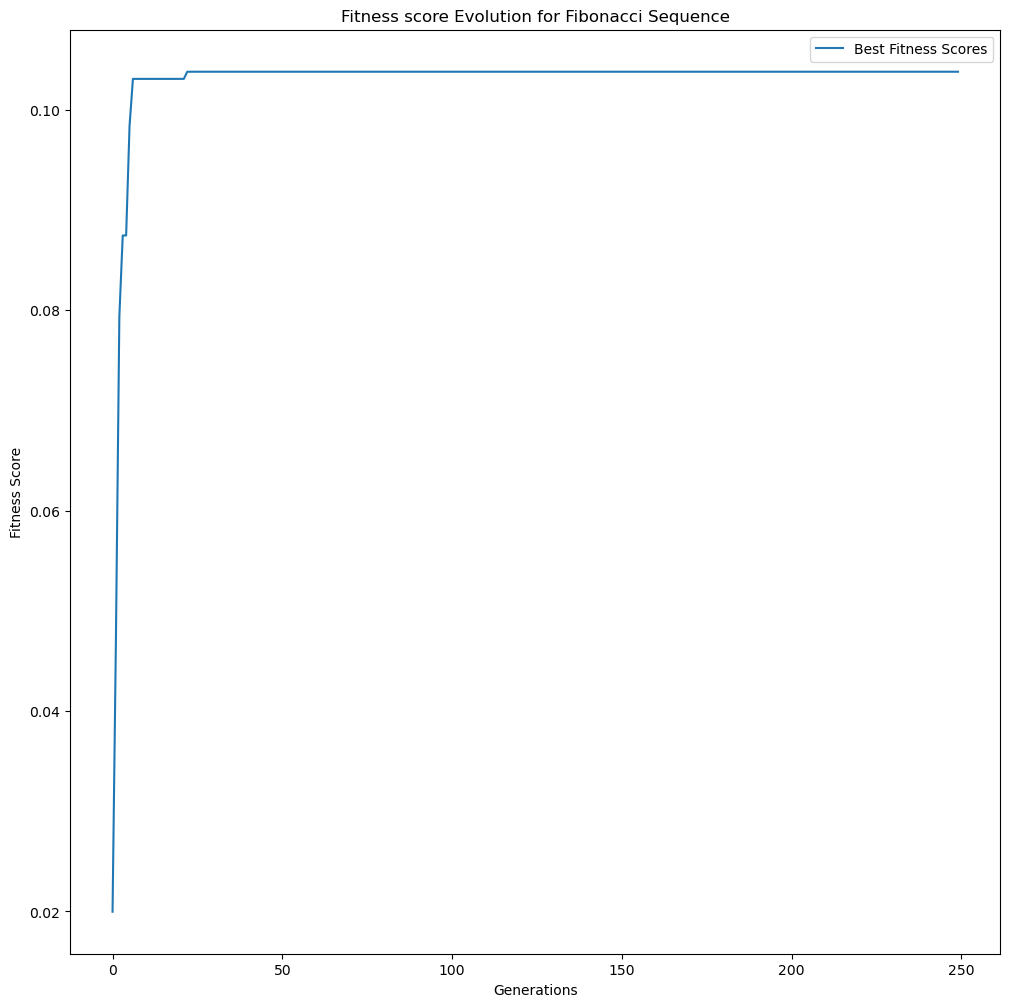

In [190]:
fig, ax = plt.subplots(1,1,figsize=(12,12))

ax.plot(range(len(history)), history, label='Best Fitness Scores')
ax.set_xlabel("Generations")
ax.set_ylabel("Fitness Score")
ax.set_title("Fitness score Evolution for Fibonacci Sequence")
ax.legend()
# fig.savefig('fibonacci.png')